In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import dask.dataframe as dd # data processing
import matplotlib.pyplot as plt # data visualisation
import seaborn as sns # data visualisation
import dataprep # data pre-processing
import category_encoders 

sns.set()

In [2]:
path = 'Data/train.csv' # training data path
data = pd.read_csv(path) # read data

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (8,9,10,11,12,43,157,196,214,225,228,229,231,235,238) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# pd.set_option('display.max_columns', 100)
data.head(10) # display top 10 rows

,ID,VAR_0001,VAR_0002,VAR_0003,VAR_0004,VAR_0005,VAR_0006,VAR_0007,VAR_0008,VAR_0009,...,VAR_1926,VAR_1927,VAR_1928,VAR_1929,VAR_1930,VAR_1931,VAR_1932,VAR_1933,VAR_1934,target
0,2,H,224,0,4300,C,0.0,0.0,False,False,...,98,98,998,999999998,998,998,9998,9998,IAPS,0
1,4,H,7,53,4448,B,1.0,0.0,False,False,...,98,98,998,999999998,998,998,9998,9998,IAPS,0
2,5,H,116,3,3464,C,0.0,0.0,False,False,...,98,98,998,999999998,998,998,9998,9998,IAPS,0
3,7,H,240,300,3200,C,0.0,0.0,False,False,...,98,98,998,999999998,998,998,9998,9998,RCC,0
4,8,R,72,261,2000,N,0.0,0.0,False,False,...,98,98,998,999999998,998,998,9998,9998,BRANCH,1
5,14,R,4,4,4422,C,0.0,0.0,False,False,...,98,98,998,999999998,998,998,9998,9998,IAPS,0
6,16,H,60,132,40000,C,1.0,1.0,False,False,...,0,1,0,999999996,400,400,9996,76,IAPS,1
7,20,R,13,75,3600,B,0.0,0.0,False,False,...,98,98,998,999999998,998,998,9998,9998,IAPS,0
8,21,R,17,16,2296,N,1.0,1.0,False,False,...,0,97,997,999999997,400,997,9996,90,MOBILE,1
9,22,R,24,72,450,N,0.0,0.0,False,False,...,98,98,998,999999998,998,998,9998,9998,BRANCH,0


In [4]:
# number of rows and columns in dataset
rows = data.shape[0]
columns = data.shape[1]
print("Data has {} rows, {} columns".format(rows, columns))

Data has 145231 rows, 1934 columns


# DATA PREPROCESSING

## Handle Nulls

In [5]:
# number of nulls in dataset
nulls = (data.isna().sum()/rows)*100

# columns with more than 25% nulls
columns_to_remove = []

# columns with nulls
null_columns = []

for i in nulls.index:
    if(nulls[i] >= 25):
        columns_to_remove.append(i)
    elif(nulls[i]>0):
        null_columns.append(i)


In [6]:
# drop columns with more than 25% of nulls
data = data.drop(columns_to_remove, axis = 1)

print("Columns remaining are {}".format(data.shape[1]))

Columns remaining are 1910


In [7]:
# dropping rows with nulls (atmost 0.68% values are null in a null_columns)
data = data.dropna().reset_index(drop = True)

## Clean Data

In [8]:
# categorical variables
cat_vars = []

for i in data.columns:
    if(data[i].dtype == 'object'):
        cat_vars.append(i)

In [9]:
# columns to drop (with same value across the dataset)
to_drop = ["ID", "VAR_0236", "VAR_0239", "VAR_0075", "VAR_0204", "VAR_0217"]

for i in cat_vars:
    if len(data[i].value_counts().index) == 1:
        to_drop.append(i)

In [10]:
data = data.drop(to_drop, axis = 1)

## Handle Categorical variables

In [11]:
# encode categorical variable using LeaveOneOutEncoding technique
from category_encoders import LeaveOneOutEncoder

# columns to encode
encode_cols = []

# binary categorical columns
bin_cat_cols = []

for i in data.columns:
#     categorical columns remaining
    if(i in cat_vars and not (i in to_drop)):
        if(len(data[i].value_counts().index)>2):
#             non-binary valued columns
            encode_cols.append(i)
        else:
#             binary valued columns
            bin_cat_cols.append(i)

# intialise encoder
encoder = LeaveOneOutEncoder(cols = encode_cols)

In [12]:
# data prep for encoding
X = data.drop(['target'], axis = 1)
y = data['target']

# fit and encode data
data = encoder.fit_transform(X, y)
data['target'] = y

In [13]:
data.reset_index(drop = True, inplace = True)

In [14]:
# encode binary categorical variables
bin_code = {True : 1, False : 0}

data = data.replace(bin_code)

data['VAR_0466'] = data['VAR_0466'].replace({'I':1, "-1":0})

In [15]:
# remove columns where min value is same as 75th percentile value
columns_to_remove = []

# threshold
threshold_quantile = 0.75
for i in data.columns:
    if(min(data[i]) == data[i].quantile(threshold_quantile) and i != 'target'):
        columns_to_remove.append(i)

print("Columns with same minimum and {}th percentile are {}".format(threshold_quantile, len(columns_to_remove)))

Columns with same minimum and 0.75th percentile are 519


In [16]:
data = data.drop(columns_to_remove, axis = 1)

## Handle Outliers

In [17]:
def handleOutliers(data, to_return = False):
    ''' 
    Removes outliers from each column and reports the data loss
    
    Args:
        data (DataFrame) : The DataFrame to remove outliers from
        to_return (bool) :  - Default value False
                            - Whether to return the DataFrame after removing outliers
    
    Returns:
        DataFrame : data free from outliers
    '''
#     calculate first quantile
    Q1 = data.quantile(0.25)
#     calculate third quantile
    Q3 = data.quantile(0.75)
#     calculate inter quartile range
    IQR1 = Q3-Q1

#     initialise data w/o outliers (drop outliers)
    data_c = data[~((data < (Q1-1.5*IQR1))|(data > (Q3+1.5*IQR1))).any(axis = 1)] 
    
#     report data loss
    print('Data loss is {}%'.format(((len(data) - len(data_c))/len(data))*100))
    
    if(to_return):
        return data_c.reset_index(drop = True)

In [18]:
handleOutliers(data.drop(['target'], axis = 1))

Data loss is 100.0%


### Considering each feature individually for outlier analysis

In [19]:
def countOutliers(data, column):
    ''' 
    Calculates the number of outliers in given column
    
    Args:
        data (DataFrame) : The dataset in form of Pandas DataFrame
        column (string) : The column to report number of outliers in
    
    Returns:
        int : percentage of outliers in column
    '''
#     calculate first quantile
    Q1 = data[column].quantile(0.25)
#     calculate third quantile
    Q3 = data[column].quantile(0.75)
#     calculate inter quartile range
    IQR1 = Q3-Q1
    
#     % of outliers in the column
    return (len(data[((data[column] < (Q1-1.5*IQR1))|(data[column] > (Q3+1.5*IQR1)))])/len(data))*100

In [20]:
# percentage of outliers in each column
outliers = {}

for column in data.columns:
    outliers[column] = countOutliers(data, column)

In [21]:
# sort in decreasing order
outliers = dict(sorted(outliers.items(), key=lambda item: item[1], reverse = True))

# threshold percentage of outliers
threshold_outliers = 0

# remove columns with more than threshold
to_drop_outliers = []

for i in outliers:
    if(outliers[i] <= threshold_outliers):
        break
    elif(i != 'target'):
        to_drop_outliers.append(i)

print("Columns with more than {}% of values as Outliers are {}".format(threshold_outliers, len(to_drop_outliers)))

Columns with more than 0% of values as Outliers are 927


In [22]:
# drop columns with oultiers
data_c = data.drop(to_drop_outliers, axis = 1)

In [23]:
# check presence of outliers
handleOutliers(data_c.drop(['target'], axis = 1))

Data loss is 0.0%


In [24]:
data = data_c

## Split into Train & Validation parts

In [37]:
from sklearn.model_selection import train_test_split

# dependent variables
X = data.drop(['target'], axis = 1)
# independent variable
y = data['target']

# split data into train and validation part
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 5)

## Scale Value

In [26]:
from sklearn.preprocessing import StandardScaler

# intialise StandardScaler
scaler = StandardScaler()

# Scale training data
X_train_scaled = scaler.fit_transform(X_train)

# Scale validation data
X_val_scaled = scaler.transform(X_val)

## Dimensionality Reduction

### Hyperparameters : 
#1 reduceDim : threshold_PCA

In [27]:
from sklearn.decomposition import PCA

def reduceDim(X_train, threshold_PCA):
    ''' 
    Calculates number of Principal Components to retain 
    atleast "threshold" variance
    
    Args:
        X_train (DataFrame) : The training dataset in form of Pandas DataFrame
        threshold_PCA (float) : Minimum value of variance to retain
    
    Returns:
        PCA object : The PCA instance to transform validation and test data
        DataFrame : The transformed training dataset
    '''
#     intialise PCA
    pca = PCA(n_components = threshold_PCA)
#     fit and transform training data
    X_train_PCA = pca.fit_transform(X_train)
    
#     print info
    print("Number of columns retained : {} \nNumber of columns in original dataset : {}"
          .format(X_train_PCA.shape[1], X_train.shape[1]))
    
    return (pca, X_train_PCA)

In [38]:
pca, X_train_PCA = reduceDim(X_train_scaled, 0.99)

Number of columns retained : 119 
Number of columns in original dataset : 445


In [39]:
# apply PCA to validation data
X_val_PCA = pca.transform(X_val_scaled)

## Handle Class Imbalance

In [32]:
from imblearn.over_sampling import SMOTE #to over sample minority class (outcome = 1)
from imblearn.under_sampling import RandomUnderSampler #to under sample majority class (outcome = 0)

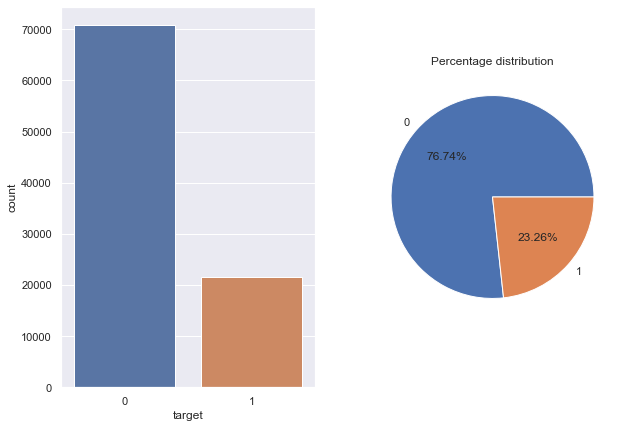

In [33]:
f, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 7)) # set up plot 

# visualise distribution in Ytrain

sns.countplot(x = y_train, ax = ax[0]) # plot bar plot

# plot a pie chart
ax[1].pie(x = y_train.value_counts().values, labels = y_train.value_counts().index, autopct = "%.2f%%")
ax[1].set_title("Percentage distribution") # set title

# display plots
plt.show()

In [45]:
# apply SMOTE to balance target variable
smote = SMOTE(sampling_strategy = 1, k_neighbors = 5, random_state = 9)
# undersample Majority class (target = 1)
under = RandomUnderSampler(sampling_strategy = 1, random_state = 9) 

X_train_bal, y_train_bal = smote.fit_resample(X_train_PCA, y_train) #apply oversampling
X_train_bal, y_train_bal = under.fit_resample(X_train_bal, y_train_bal) #apply undersampling

## Correct Skewness

In [82]:
def removeSkew(X, skew_index):
    ''' 
    Removes columns with skew distribution using "skew_index" array
    
    Args:
        X (Numpy Array) : The dataset to remove skew columns from
        skew_index (Numpy Array) : List of columns to remove from "X"
    
    Returns:
        Numpy Array : The data without skew columns
    '''
    return np.array(pd.DataFrame(X).drop(skew_index, axis=1))

In [83]:
# conver NP array to pandas DF
skew = pd.DataFrame(X_train_bal).skew()

# columns with asymmetrical distribution
skew_index = np.array(skew[~((skew>=-0.5) & (skew <= 0.5))].index)

print("Number of columns with skew distribution : {}".format(len(skew_index)))

# remove skewed columns
X_train_normal = removeSkew(X_train_bal, skew_index)
X_val_normal = removeSkew(X_val_PCA, skew_index)

Number of columns with skew distribution : 13


# Machine Learning

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV #import GridSearchCV

params = {'C' : [0.0001, 0.0003, 0.0005, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5]} # values of C parameter in LR to try for

clf_lr = GridSearchCV(LogisticRegression(), params) # Logistic Regression

clf_lr.fit(Xtrain, Ytrain) # train LR model